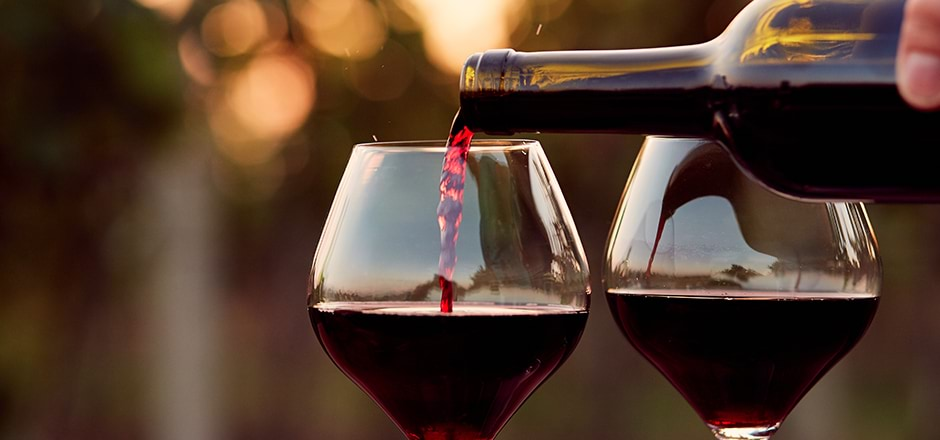

In this kernel, I will investigate the ["Red Wine Quality"](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009) dataset created by the UCI Machine Learning department and uploaded to Kaggle. I will begin with a short EDA section and then preparing the data, if necessary, before creating a machine learning model. I will then select a model and fine tun it.

### Contents

1. [Libraries](#1.-Import-libraries)
2. [Data Loading](#2.-Data-information)
3. [Data Preprocessing](#3.-Data-preprocessing)
4. [Data Visualization](#4.-Data-visualization)
5. [Creating Functions](#5.-Functions-for-model-visualization)
4. [Model Selection](#6.-Model-Selection)
5. [Model Tuning](#7.-Random-Forest-hyper-tuning)
6. [Conclusion](#8.-Conclusion)

### 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

warnings.filterwarnings("ignore")

sns.set_style('darkgrid')

### 2. Data information

In [33]:
data = pd.read_csv('winequality-red.csv')

data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### 3. Data preprocessing

In [3]:
data.shape

(1599, 12)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
data.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [6]:
data.describe().T.style.background_gradient(axis=0)

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.000000,8.319637,1.741096,4.600000,7.100000,7.900000,9.200000,15.900000
volatile acidity,1599.000000,0.527821,0.179060,0.120000,0.390000,0.520000,0.640000,1.580000
citric acid,1599.000000,0.270976,0.194801,0.000000,0.090000,0.260000,0.420000,1.000000
residual sugar,1599.000000,2.538806,1.409928,0.900000,1.900000,2.200000,2.600000,15.500000
chlorides,1599.000000,0.087467,0.047065,0.012000,0.070000,0.079000,0.090000,0.611000
free sulfur dioxide,1599.000000,15.874922,10.460157,1.000000,7.000000,14.000000,21.000000,72.000000
total sulfur dioxide,1599.000000,46.467792,32.895324,6.000000,22.000000,38.000000,62.000000,289.000000
density,1599.000000,0.996747,0.001887,0.990070,0.995600,0.996750,0.997835,1.003690
pH,1599.000000,3.311113,0.154386,2.740000,3.210000,3.310000,3.400000,4.010000
sulphates,1599.000000,0.658149,0.169507,0.330000,0.550000,0.620000,0.730000,2.000000


### 4. Data visualization

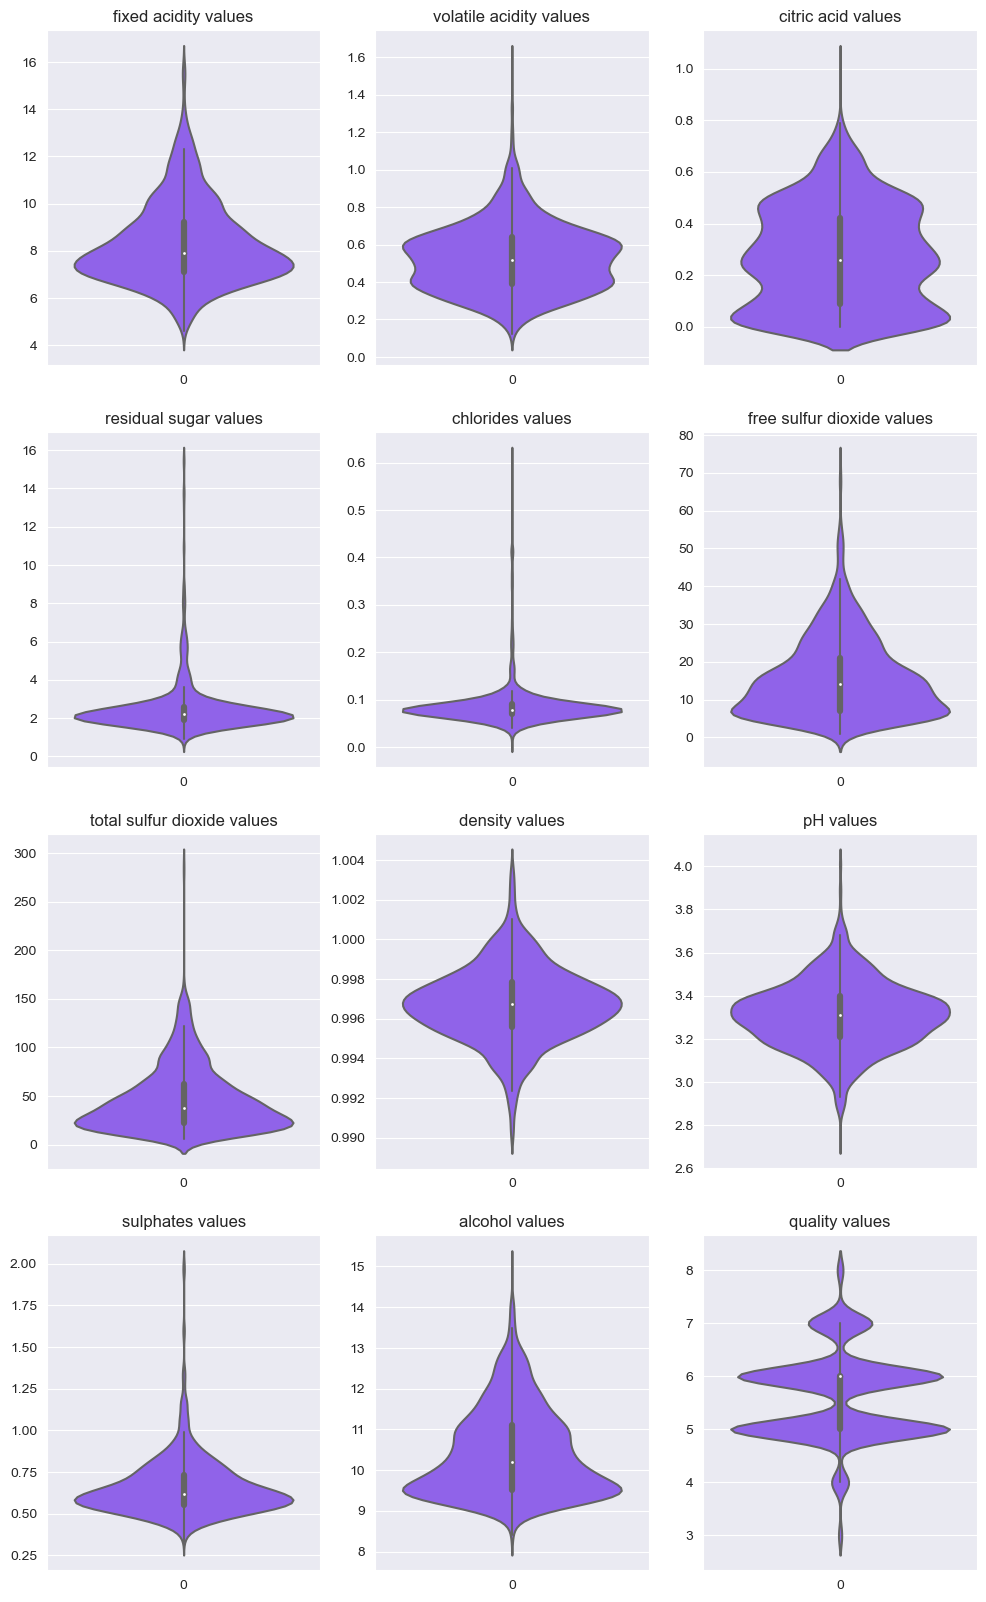

In [7]:
fig, axes = plt.subplots(4, 3, figsize=(12, 20))

axes = axes.flatten()

for i, column in enumerate(data.columns):
    sns.violinplot(data[column], ax=axes[i], color='#884dff')
    axes[i].set_title(f"{column} values")

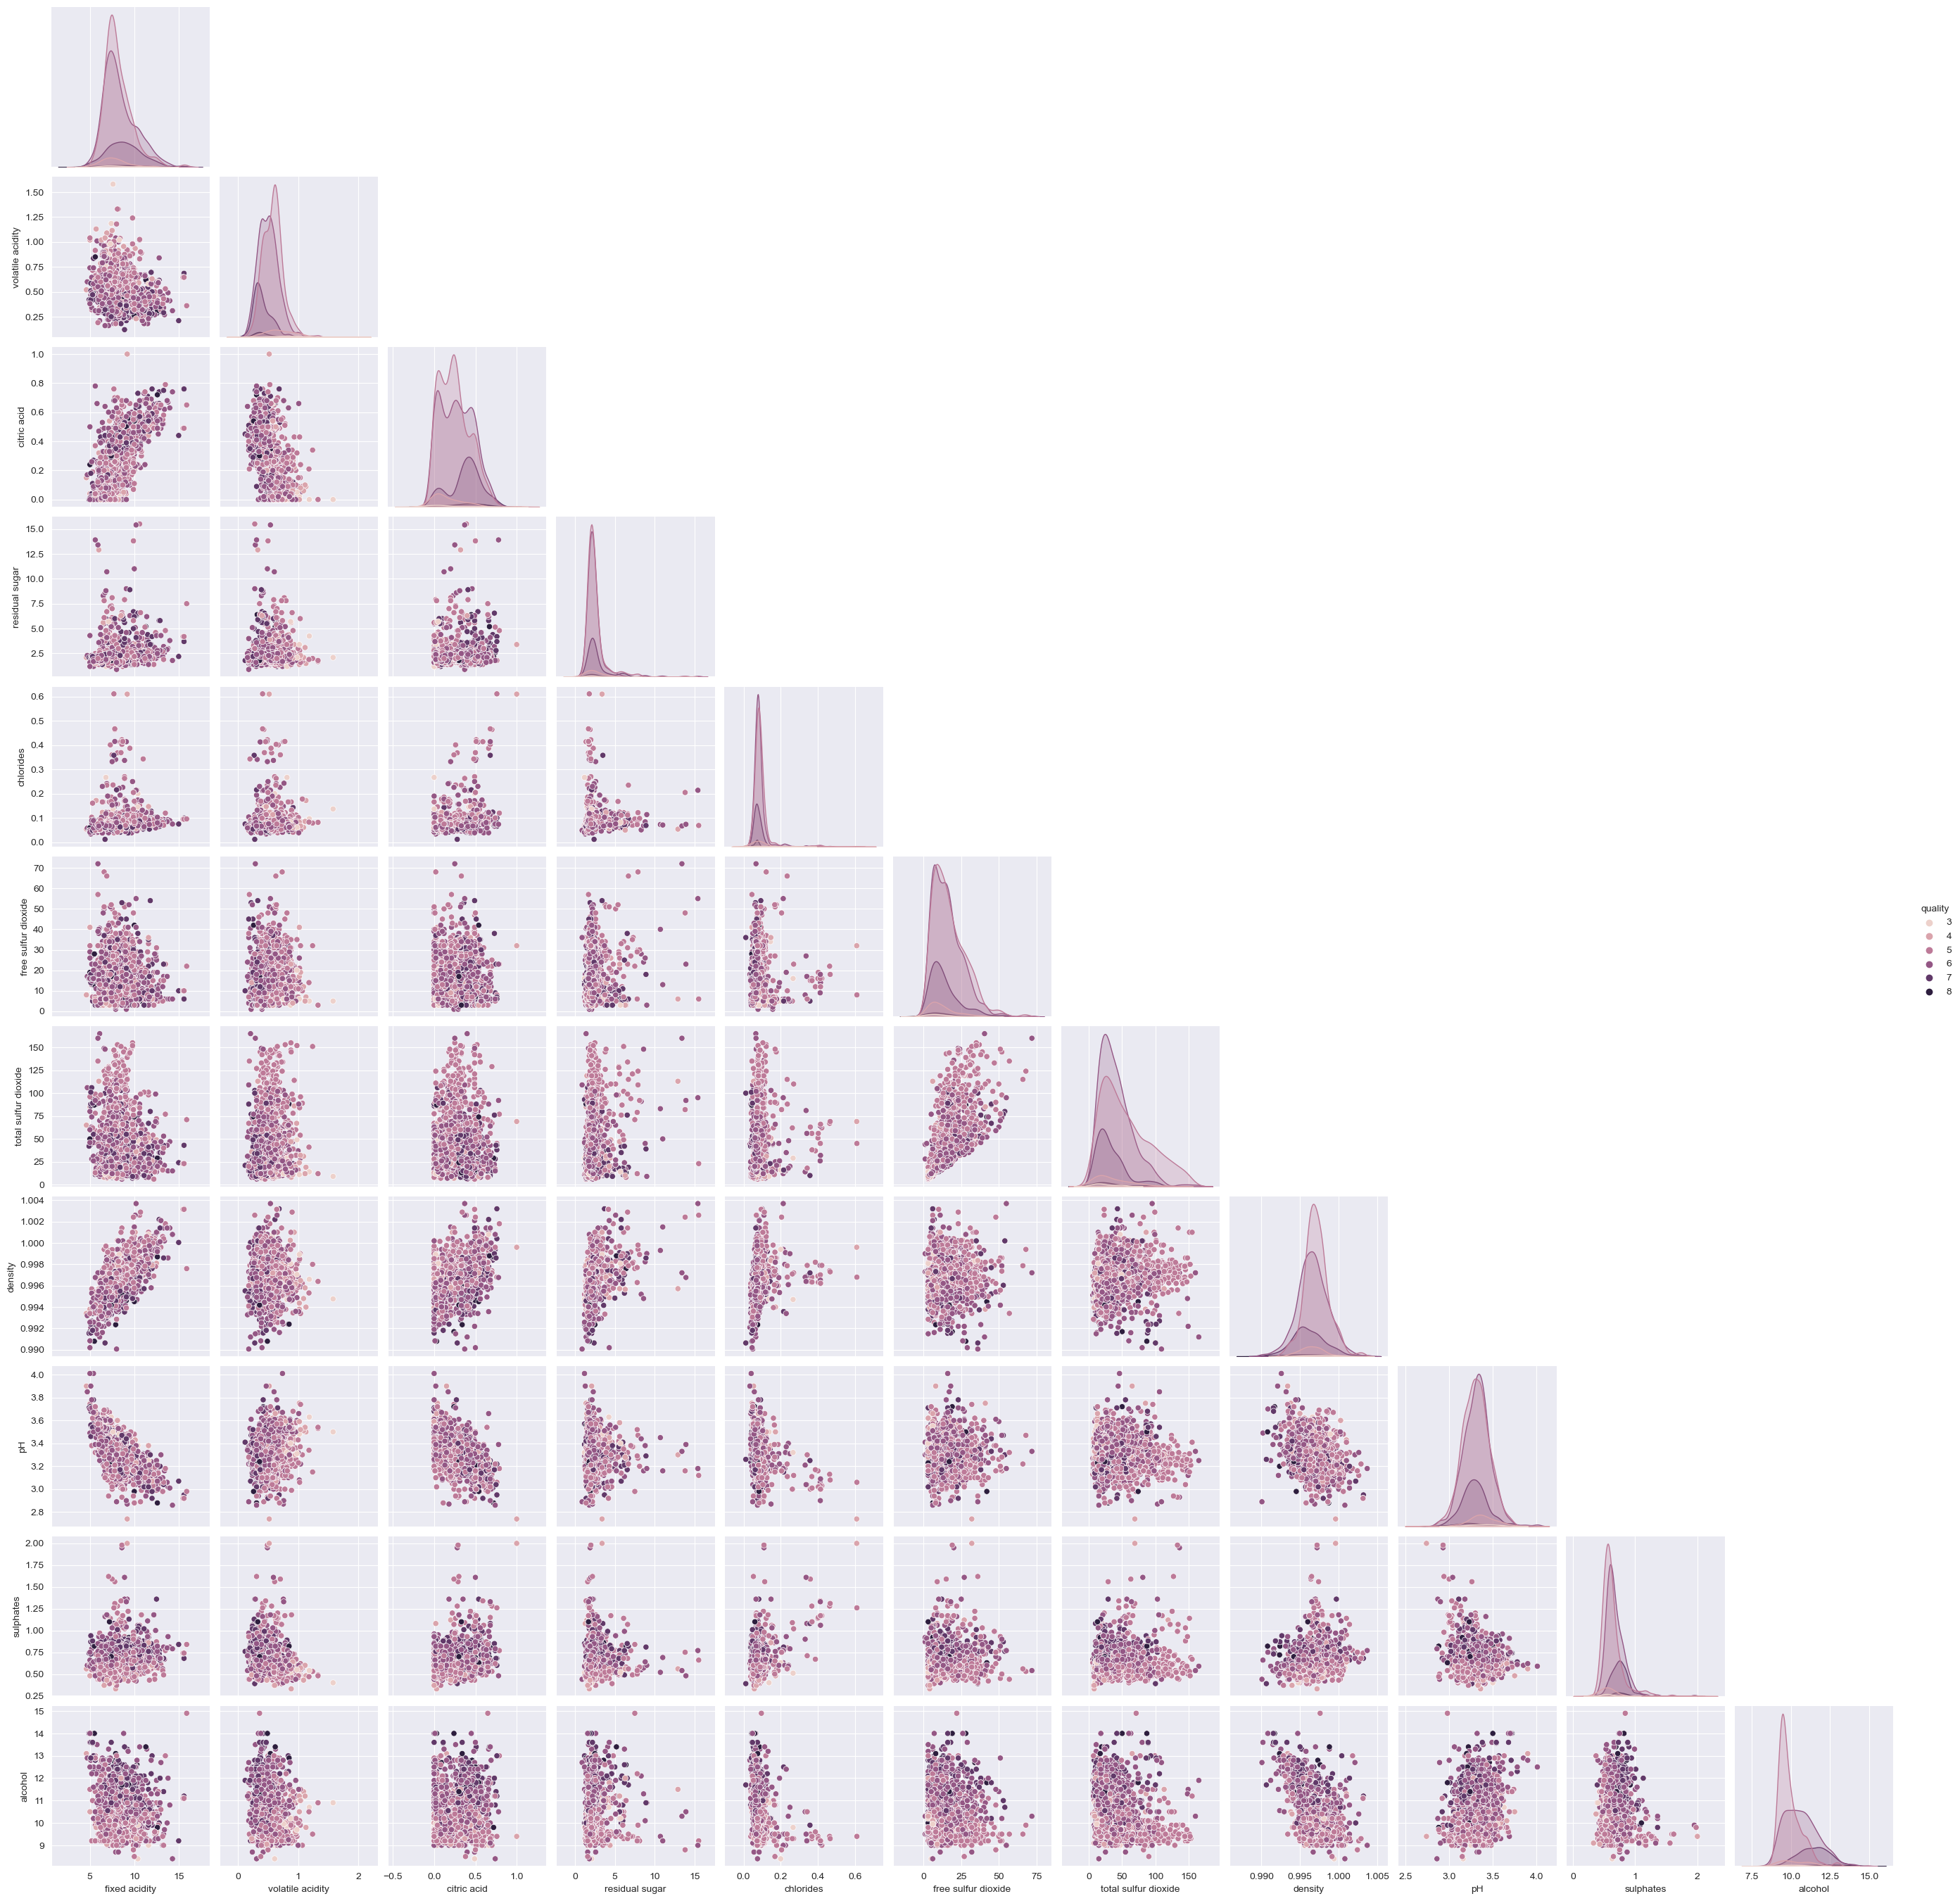

In [40]:
sns.pairplot(data, corner=True, hue='quality')

We'll remove somme of the obvious __noise__ in the total sulfur dioxide plots.

In [38]:
index = data.loc[data['total sulfur dioxide'] > 200].index

data.drop(index=index, inplace=True)

<Axes: >

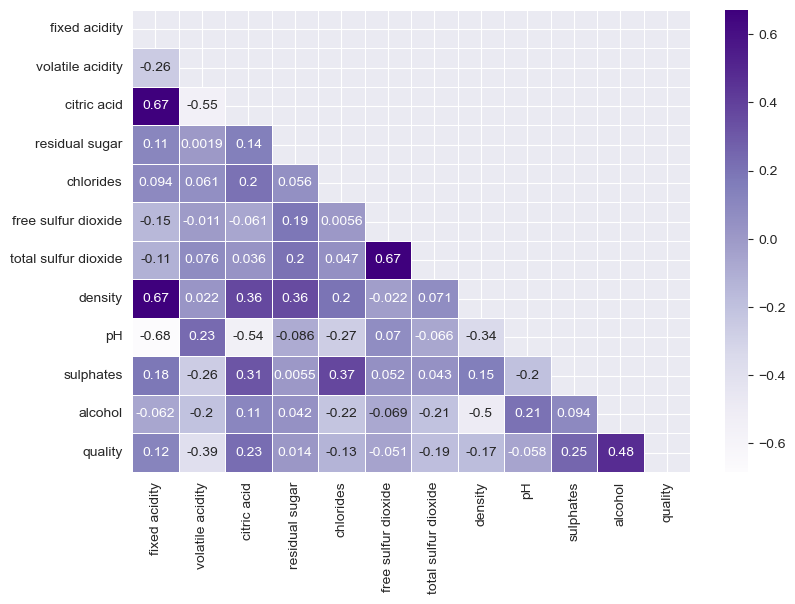

In [9]:
plt.figure(figsize=(9, 6))

sns.heatmap(data.corr(), annot=True, linewidth=0.5, cmap='Purples', mask=np.triu(data.corr()))

Text(0.5, 1.0, 'Correlation: 0.6677')

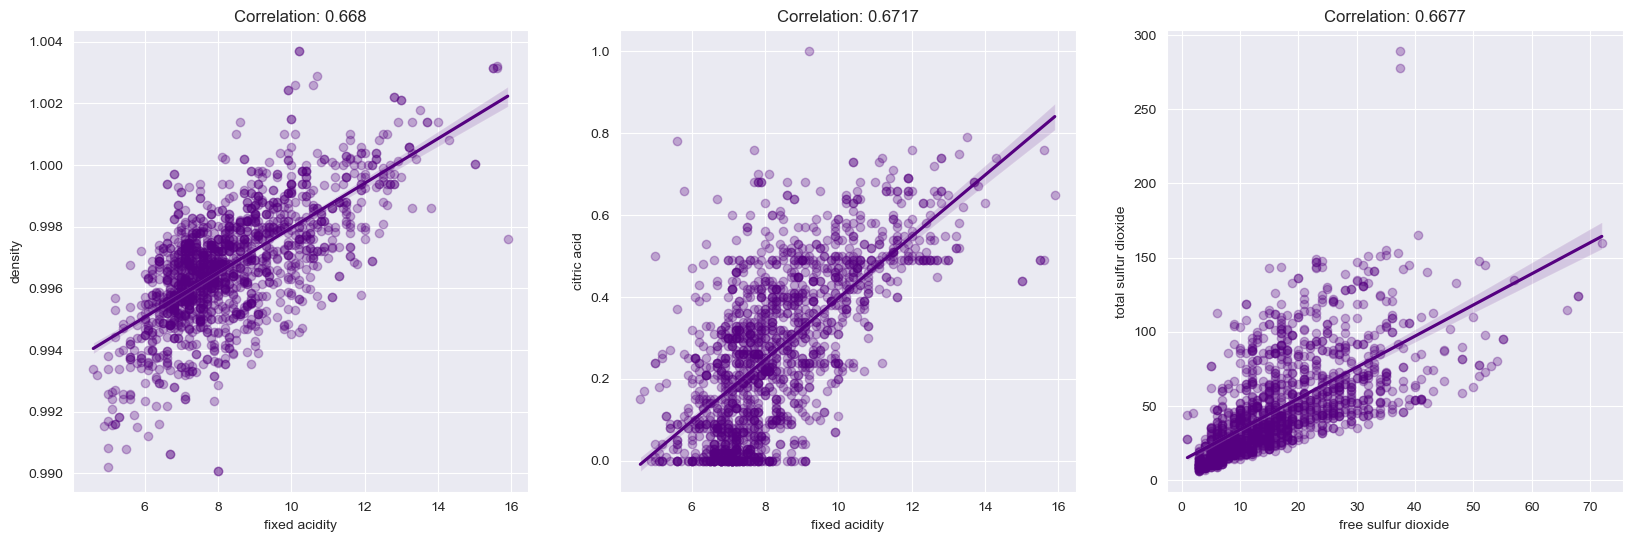

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes = axes.flatten()

sns.regplot(data=data, x='fixed acidity', y='density', ax=axes[0], color='#550080', scatter_kws={'alpha':0.3})
axes[0].set_title(f"Correlation: {round(data['fixed acidity'].corr(data['density']), 4)}")

sns.regplot(data=data, x='fixed acidity', y='citric acid', ax=axes[1], color='#550080', scatter_kws={'alpha':0.3})
axes[1].set_title(f"Correlation: {round(data['fixed acidity'].corr(data['citric acid']), 4)}")

sns.regplot(data=data, x='free sulfur dioxide', y='total sulfur dioxide', ax=axes[2], color='#550080', scatter_kws={'alpha':0.3})
axes[2].set_title(f"Correlation: {round(data['free sulfur dioxide'].corr(data['total sulfur dioxide']), 4)}")

Text(0.5, 1.0, 'Quality Value Counts')

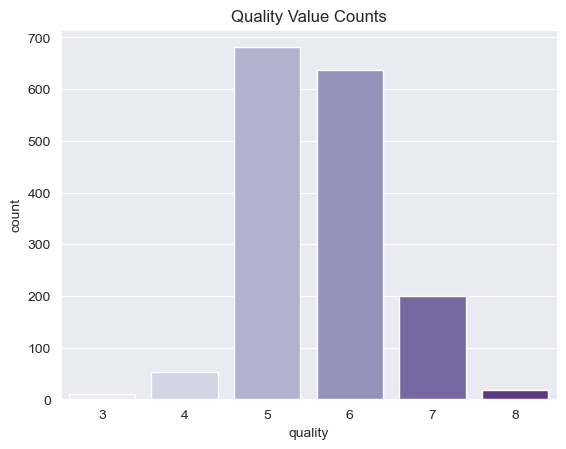

In [11]:
sns.countplot(data=data, x=data['quality'], palette='Purples')
plt.title('Quality Value Counts')

### 5. Functions for model visualization

In [12]:
# function to plot confusion matrix
def plot_confusion_matrix(y_test, y_prediction):
    '''Plotting Confusion Matrix'''
    cm = metrics.confusion_matrix(y_test, y_prediction)
    ax = plt.subplot()
    ax = sns.heatmap(cm, annot=True, fmt='', cmap="Purples", xticklabels=model.classes_, yticklabels=model.classes_)
    ax.set_xlabel('Predicted', fontsize=18)
    ax.set_ylabel('Actual', fontsize=18)
    ax.set_title('Confusion Matrix', fontsize=25)
    plt.show()

In [13]:
# function to plot classification report
def clfr_plot(y_test, y_pred) :
    ''' Plotting Classification report'''
    cr = pd.DataFrame(metrics.classification_report(y_test, y_pred_rf, digits=3,
                                            output_dict=True)).T
    cr.drop(columns='support', inplace=True)
    sns.heatmap(cr, cmap='Purples', annot=True, linecolor='white', 
                linewidths=0.5, xticklabels=model.classes_, yticklabels=model.classes_).xaxis.tick_top()

In [23]:
# function to plot both
def clf_plot(y_pred) :
    '''
    1) Ploting Confusion Matrix
    2) Plotting Classification Report'''
    cm = metrics.confusion_matrix(y_test, y_pred)
    cr = pd.DataFrame(metrics.classification_report(y_test, y_pred, digits=3, output_dict=True)).T
    cr.drop(columns='support', inplace=True)
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    # Left AX : Confusion Matrix
    ax[0] = sns.heatmap(cm, annot=True, fmt='', cmap="Purples", ax=ax[0])
    ax[0].xaxis.set_ticklabels([3, 4, 5, 6, 7, 8])
    ax[0].yaxis.set_ticklabels([3, 4, 5, 6, 7, 8])
    ax[0].set_xlabel('Predicted', fontsize=18)
    ax[0].set_ylabel('Actual', fontsize=18)
    ax[0].set_title('Confusion Matrix', fontsize=25)
    
    # Right AX : Classification Report
    ax[1] = sns.heatmap(cr, cmap='Purples', annot=True, linecolor='white', linewidths=0.5, ax=ax[1])
    ax[1].xaxis.tick_top()
    ax[1].set_title('Classification Report', fontsize=25)
    plt.show()

### 6. Model Selection

In [56]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=1),
    'Random Forest': RandomForestClassifier(random_state=1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=1),
    'AdaBoost': AdaBoostClassifier(random_state=1),
    'Support Vector Machine': SVC(random_state=1),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=1),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(max_iter=1000, random_state=1),
}

In [57]:
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name}: Mean Accuracy = {np.mean(scores):.4f}, Std = {np.std(scores):.4f}")

Logistic Regression: Mean Accuracy = 0.5911, Std = 0.0323
Random Forest: Mean Accuracy = 0.6708, Std = 0.0124
Gradient Boosting: Mean Accuracy = 0.6466, Std = 0.0206
AdaBoost: Mean Accuracy = 0.5325, Std = 0.0317
Support Vector Machine: Mean Accuracy = 0.6231, Std = 0.0335
K-Nearest Neighbors: Mean Accuracy = 0.5590, Std = 0.0110
Decision Tree: Mean Accuracy = 0.5833, Std = 0.0129
Naive Bayes: Mean Accuracy = 0.5325, Std = 0.0195
Neural Network: Mean Accuracy = 0.6060, Std = 0.0304


__Random Forest__ appears to be the most accurate model. Now we will tune the hyperparameters.

### 7. Random Forest hyper tuning

In [58]:
# split data into features and target
X = data.drop(columns='quality')
y = data['quality']

# normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

In [59]:
# random forest parameter grid
rf_parameters = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# initalize model
rf_model = RandomForestClassifier(random_state=1)

# grid search with cross-validation
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=rf_parameters, scoring='rf2', cv=5, n_jobs=-1)

# fit model
grid_search_rf.fit(X_train, y_train)

# find best model
best_rf = grid_search_rf.best_estimator_

# make prediction
rf_y_pred = best_rf.predict(X_test)

In [60]:
print('Best hyper parameters : ', grid_search_rf.best_params_)
print('accuracy : ', grid_search_rf.best_score_)

Best hyper parameters :  {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}
accuracy :  0.6765931372549019


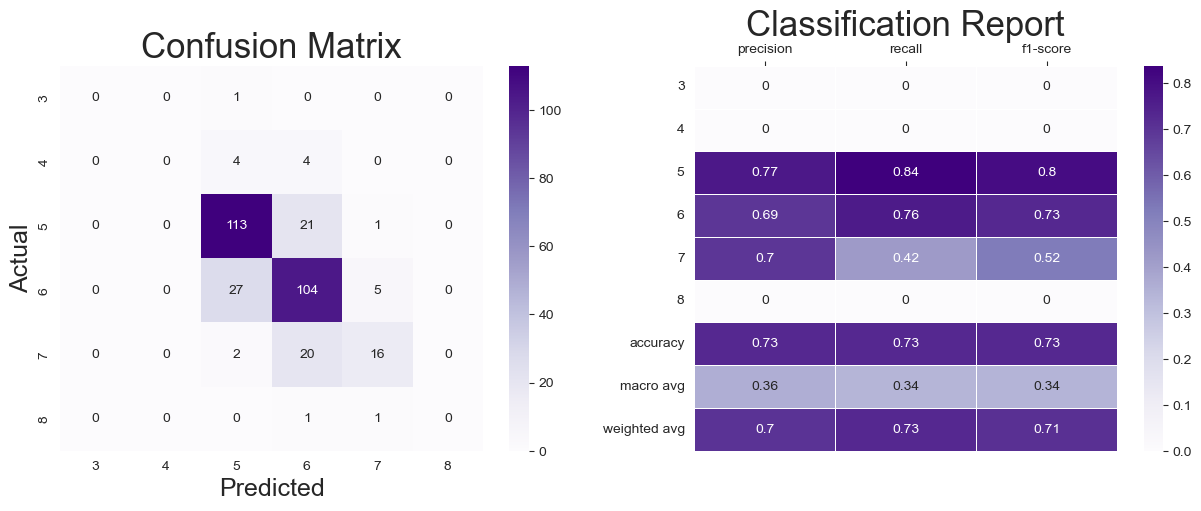

In [61]:
clf_plot(rf_y_pred)

### 8. Conclusion

Given the data available, I think we have reached the full potential of the model. In addition, the model's accuracy is fairly in line with the data given, as the model performs best on wines with quality scores of 5 or 6, as this is the majority of the data. One way to imrpove the model would be simply attaining more data for more training. Another method would be to categorize wine qualities. For example, pairing quality levels of 3 and 4 as "__Poor__," 5 and 6 as "__Decent__," and 7 and 8 as "__Good__." By limiting the number of possible outcomes I believe our model would improve by significant margins for this amount of data.